# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2 toc-item"><a href="#bias-in-recorded-daily-minima-and-maxima-induced-by-time-of-measurement" data-toc-modified-id="bias-in-recorded-daily-minima-and-maxima-induced-by-time-of-measurement-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>bias in recorded daily minima and maxima induced by time of measurement</a></div><div class="lev2 toc-item"><a href="#Proposed-solution" data-toc-modified-id="Proposed-solution-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Proposed solution</a></div><div class="lev1 toc-item"><a href="#First-Spatiotemporal-Model" data-toc-modified-id="First-Spatiotemporal-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>First Spatiotemporal Model</a></div><div class="lev1 toc-item"><a href="#Fitting-the-spatiotemporal-model" data-toc-modified-id="Fitting-the-spatiotemporal-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fitting the spatiotemporal model</a></div><div class="lev1 toc-item"><a href="#Improving-model" data-toc-modified-id="Improving-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Improving model</a></div><div class="lev1 toc-item"><a href="#Analysis" data-toc-modified-id="Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
    \newcommand{\station}[1]{\mathrm{station}\sbr{#1}}
    \newcommand{\xvec}{\mathbf{x}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
    \newcommand{\degreeC}{^\circ \mathrm{C}}
$$

In [2]:
using TimeSeries
using DataFrames
using Proj4
using DataFrames: head
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
include("src/preprocessing.jl")
include("src/utils.jl")
isdList=read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
hourly_cat=read_Stations(isdSubset)
TnTx_dict = Dict{Hour,DataFrame}()
for hr in 0:24
    hr_measure = Hour(hr) # number between 0 and 24
    hourly_cat[:ts_day] = [measurement_date(t, hr_measure) for t in hourly_cat[:ts].values]

    TnTx = DataFrames.by(hourly_cat, [:ts_day, :station], df -> DataFrame(
        Tn=minimum(df[:temp].values), 
        Tx=maximum(df[:temp].values)))
    TnTx_dict[hr_measure] = TnTx
end
waterloo = hourly_cat[hourly_cat[:station].values.==3,:]
waterloo_TnTx_dict = Dict{Hour,DataFrame}()
for hr in Hour(0):Hour(24)
    waterloo[:ts_day] = [measurement_date(t, hr) for t in waterloo[:ts].values]
    TnTx = DataFrames.by(waterloo, :ts_day, df -> DataFrame(
            Tn=minimum(df[:temp].values), 
            Tx=maximum(df[:temp].values),
            Tn_time=df[:ts].values[indmin(df[:temp].values)],
            Tx_time=df[:ts].values[indmax(df[:temp].values)],
            ))
    waterloo_TnTx_dict[hr] = TnTx
end

In [3]:
begin
    hr = Hour(23)
    low = Hour(8)
    peak = Hour(20)
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    
    apr3_low = TnTx_low[TnTx_low[:ts_day].values.==DateTime(2015,4,4),:]
    apr3_peak = TnTx_peak[TnTx_peak[:ts_day].values.==DateTime(2015,4,4),:]
    
    global apr3_realmax = get(apr3_low[1,:Tx])
    global apr3_measured = get(apr3_peak[1,:Tx])
    println(apr3_realmax)
    println(apr3_measured)
end

7.2
15.6


# Introduction

* explain the problem we're trying to solve

## bias in recorded daily minima and maxima induced by time of measurement

* explain
* demonstrate using hourly temperatures from one station: reduce to daily min and max and show difference as a function of measurement hour

We illustrate the measurement bias in daily maxima and minima with ten days of hourly temperature measurements from the Waterloo Municipal Airport station in Iowa. 
Ideally, $\Tx$ measurements should capture the peak of each diurnal cycle, and $\Tn$ its trough. 
In Figure X, those ideal measurements are indicated by the red and blue triangles respectively. 
The actual measurements are obtained by dividing the data into 24 hour measurement windows, and extracting the minimum and maximum. 
For each window, we plot these extrema with a red and blue horizontal line.

Most of the time, the ideal measurement and the actual measurement coincide: the triangle is on that day's line. 
But there are also several misses. The most blatant example occurs on April 3rd, 
where the peak of the diurnal cycle is {{apr3_realmax}}°C and occurs at 21:00 UTC. 
However, because the previous day was much warmer, the day's $\Tx$ record of {{apr3_measured}}°C is reached immediately after the previous day's measurement. 
The measured $\Tx$ therefore overestimates the diurnal cycle's peak by {{round(apr3_measured-apr3_realmax,1)}}°C.

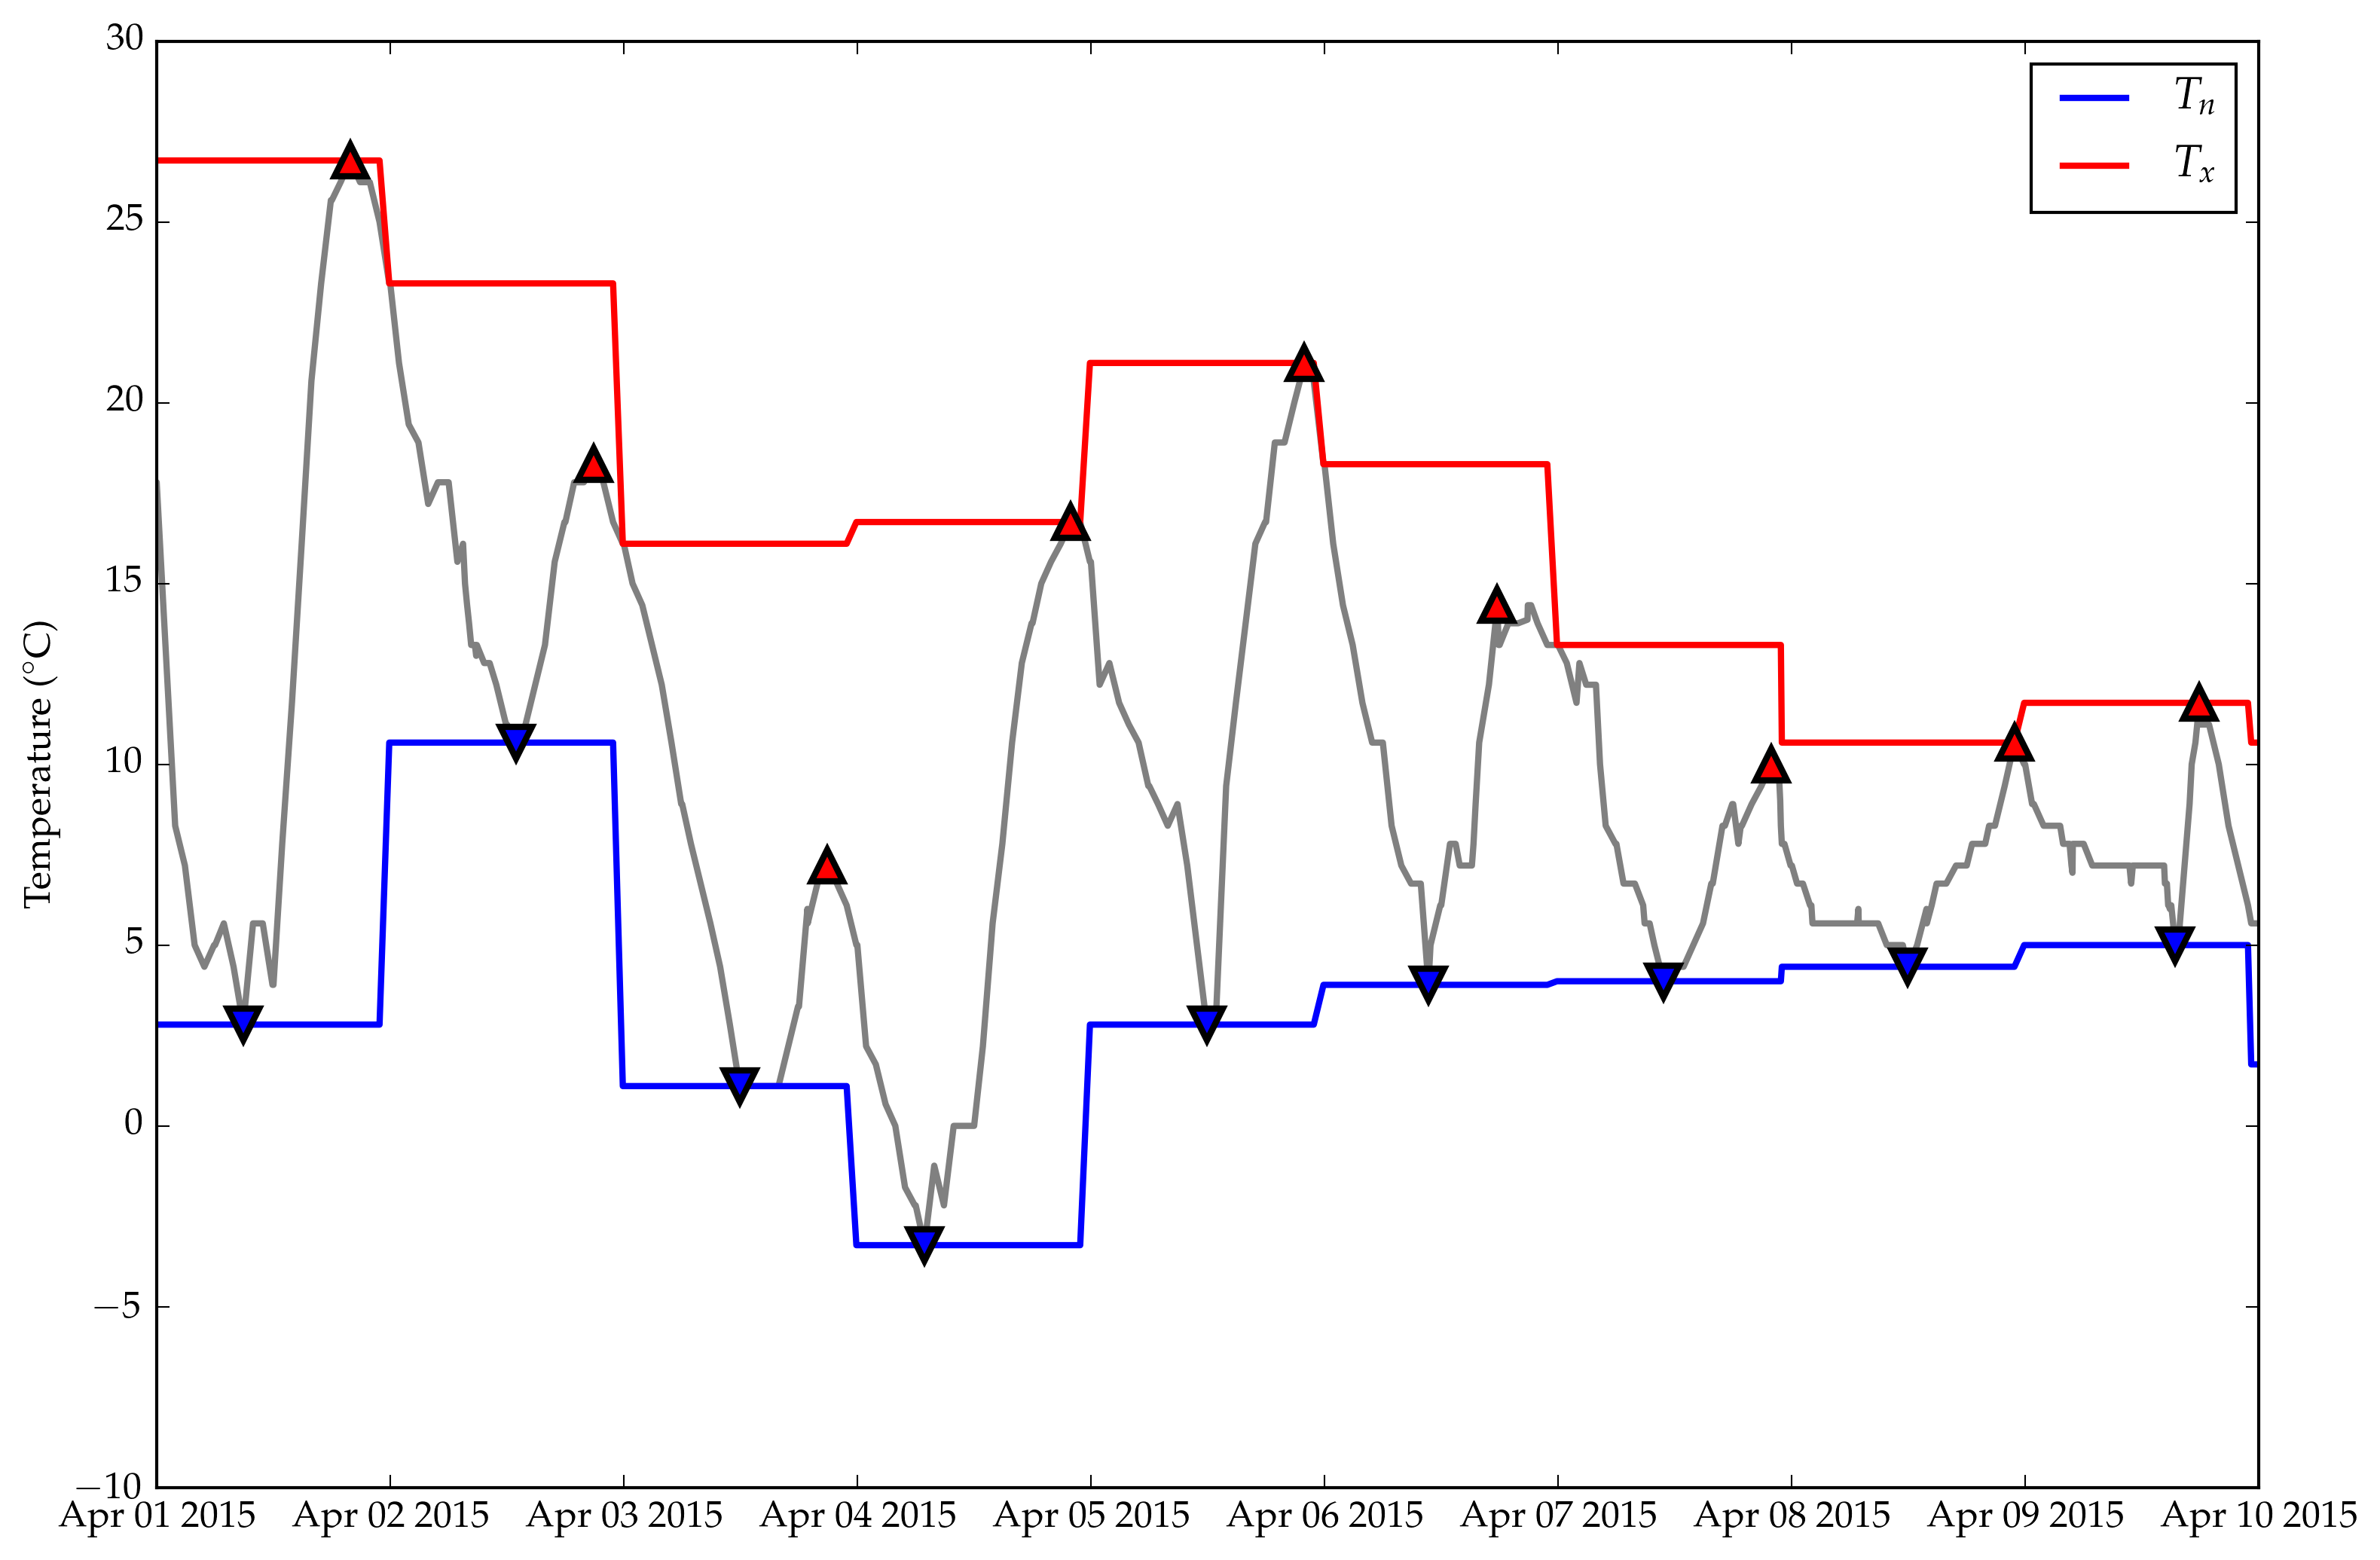

In [7]:
begin
    hr = Hour(23)
    peak = Hour(20)
    low = Hour(8)
    waterloo[:ts_day] = [measurement_date(t,hr) for t in waterloo[:ts].values]
    test_trimmed = join(waterloo, waterloo_TnTx_dict[hr], on=:ts_day)
    plt.plot(test_trimmed[:ts].values, test_trimmed[:temp].values, color="grey", linewidth=2)
    plt.plot(test_trimmed[:ts].values, test_trimmed[:Tn].values, color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test_trimmed[:ts].values, test_trimmed[:Tx].values, color="red", linewidth=2, label=L"$T_x$")
    
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    
    plt.plot(TnTx_low[:Tx_time].values, TnTx_low[:Tx].values, 
        linestyle="",
        marker="^", 
        color="red", 
        markeredgewidth=2,
        markersize=10,
        )
    plt.plot(TnTx_peak[:Tn_time].values, TnTx_peak[:Tn].values, 
        linestyle="",
        marker="v", 
        color="blue", 
        markeredgewidth=2,
        markersize=10,
        )
    plt.xlim(DateTime(2015,4,1),DateTime(2015,4,10)) # random interval
    plt.ylim(-10,30)
    plt.ylabel(L"Temperature ($^{\circ}$C)")
    plt.legend()
end;

This subtle bias in the daily records can in turn bias long-term summary statistics that are of climatological interest. 
A measure as simple as the average daily maximum temperature for an entire year (2015) increases by over 1°C if the measurements are made at the warmest time of day 21:00 UTC rather than 14:00 UTC (see Figure X).
Conversely, the average $\Tn$ is colder by over 1°C if $\Tn$ is measured at 10:00 UTC (the coldest time of day on average) rather than 17:00 UTC.

A climatologist studying weather variability might be interested in summary statistics such as the average absolute change in the daily temperature maxima and minima from one day to the next.
The answer to that question too depends on the time of day at which the temperatures are recorded.
Collecting the measurements at the hottest time of day means that the peaks on a warm day gets recorded twice, 
erasing the diurnal peaks of the following colder day, 
and hence the variability gets underestimated.
We can see this in Figure X, where the respective variability estimates drop if the maxima get measured at the warmest time, or if the minima get measured at the coldest time.

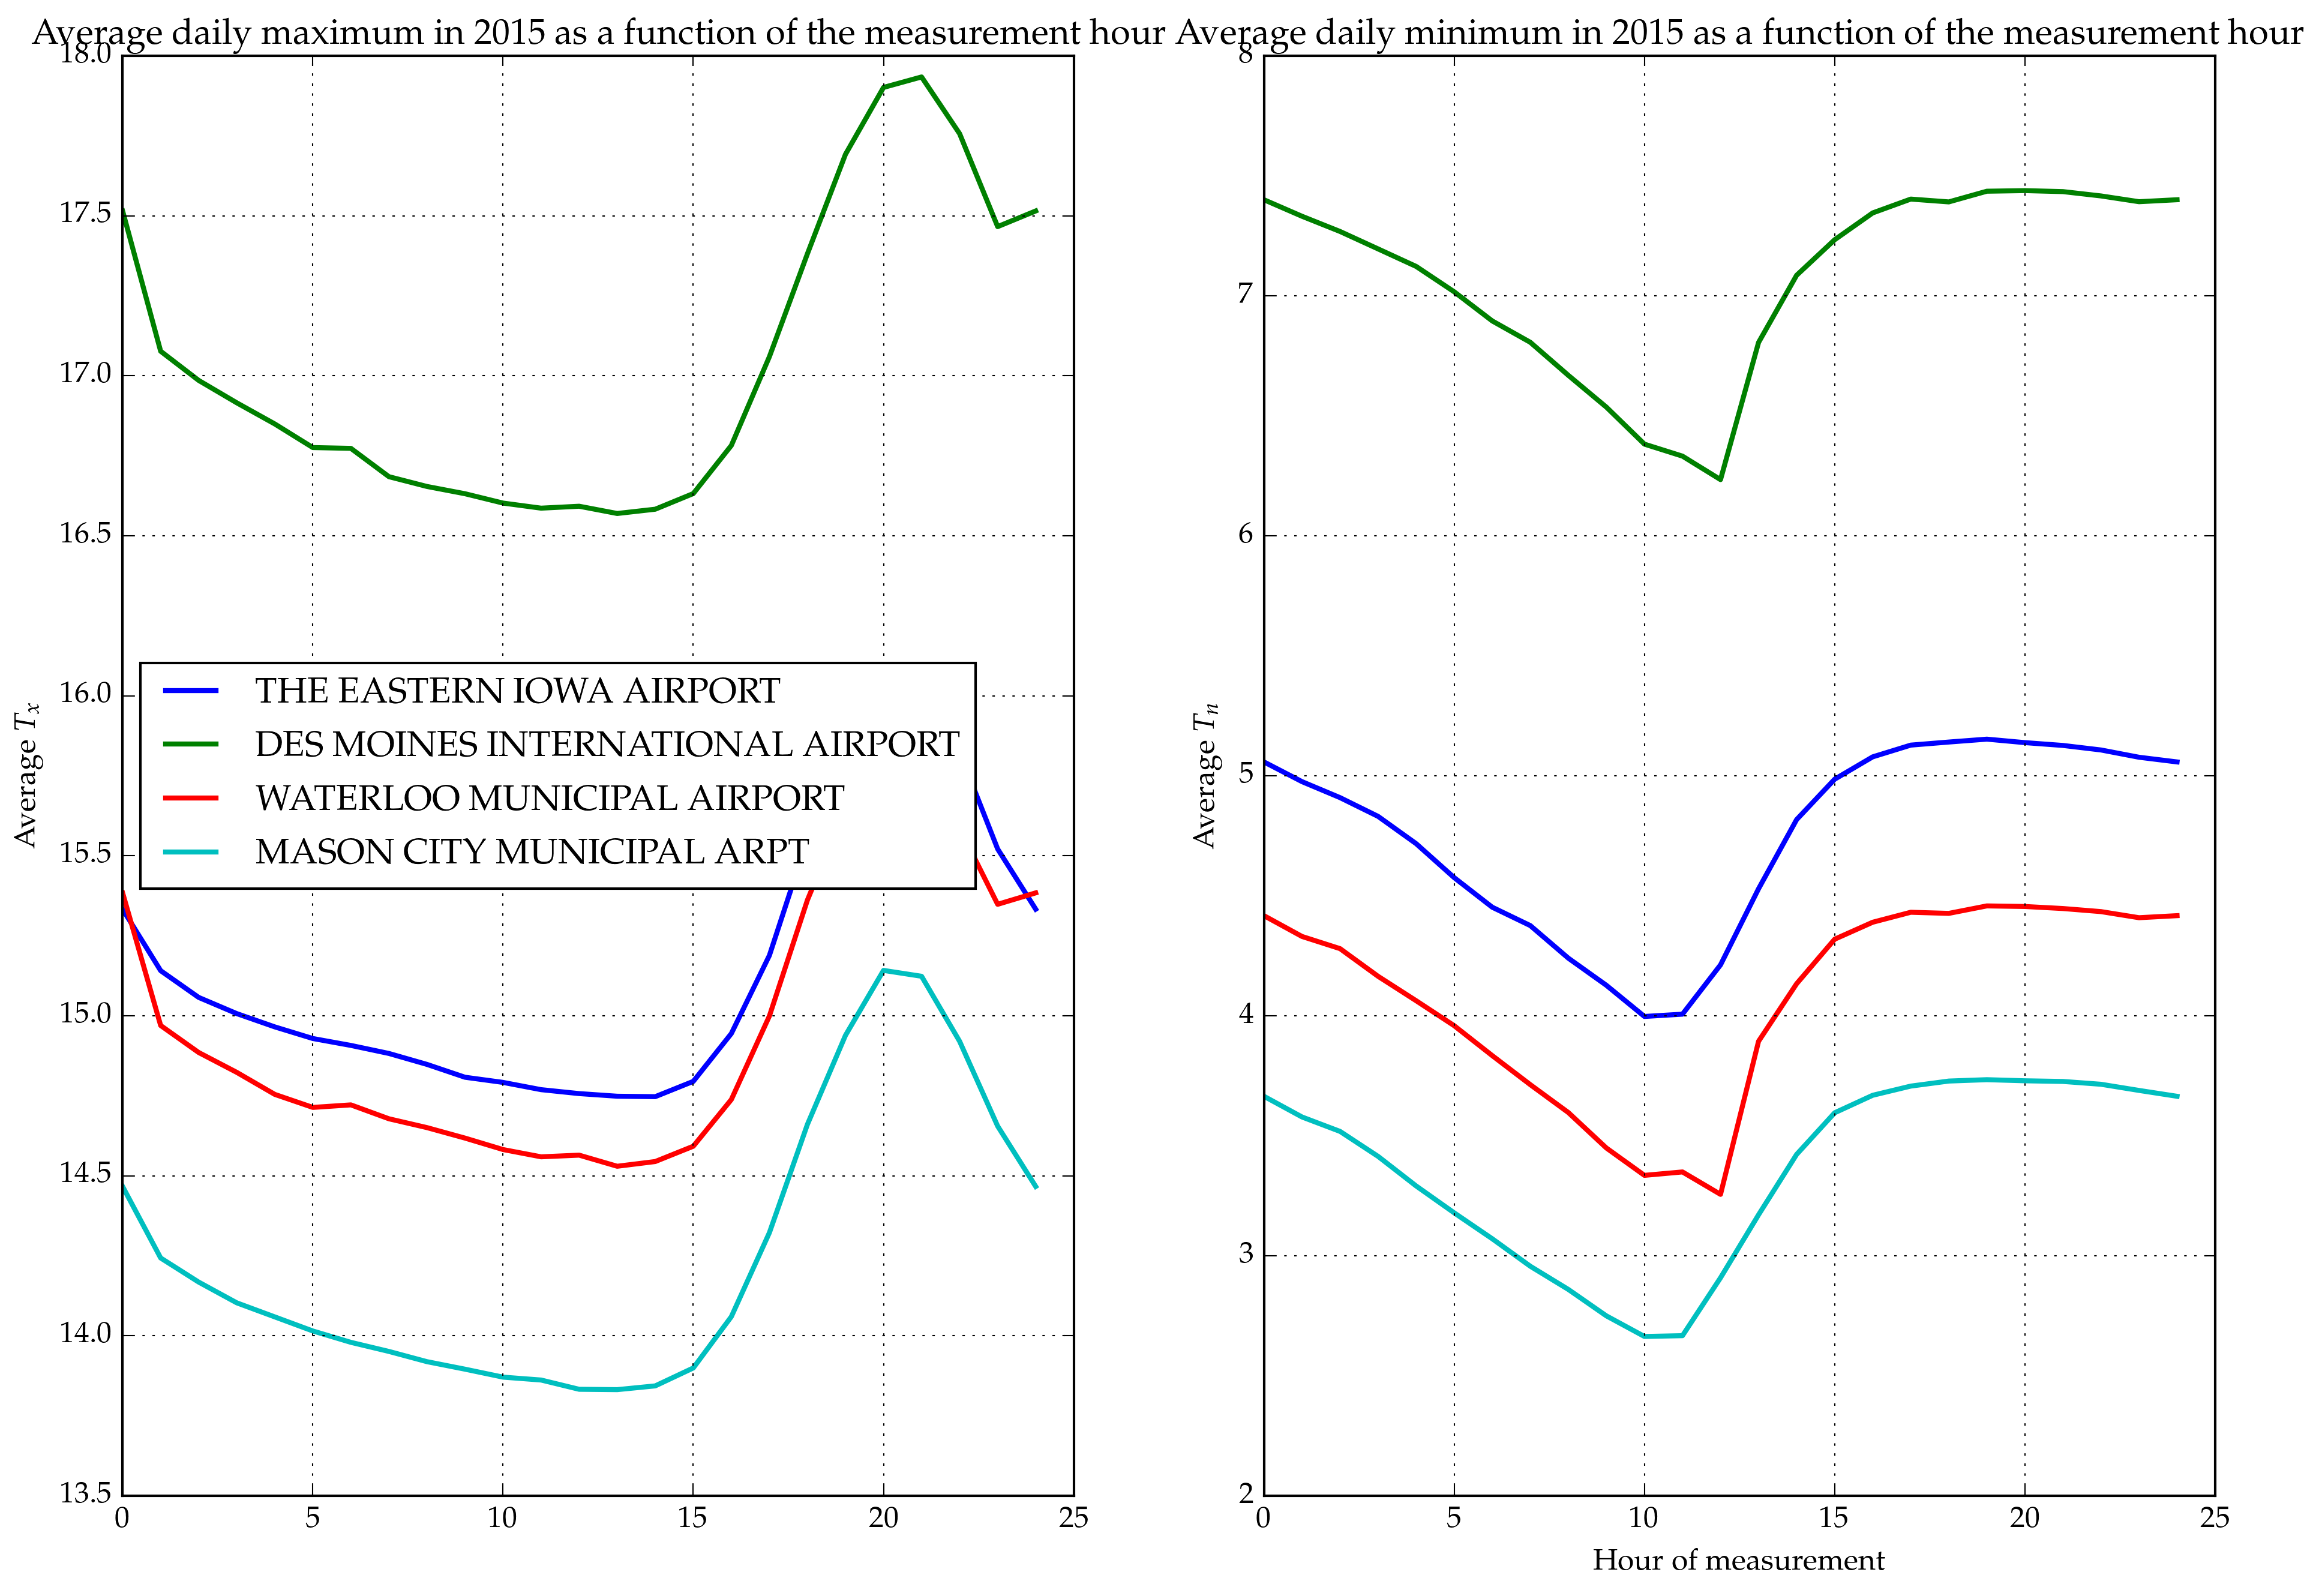

In [12]:
begin
plt.subplot(1,2,1)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for hr in Hour(0):Hour(24)
        hr_mdiff = DataFrames.by(TnTx_dict[hr], :station, 
            df -> mean(df[:Tx].values))
        for station in 1:4
            push!(statdict[station], get(hr_mdiff[station,:x1]))
        end
    end

    for station in 1:4
        plt.plot(0:24, statdict[station], linewidth=2, label=get(isdSubset[station,:NAME]))
    end
    plt.ylabel(L"Average $T_x$")
    plt.title("Average daily maximum in 2015 as a function of the measurement hour")
    plt.grid(true)
    plt.legend(loc="center left")
end
plt.subplot(1,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for hr in Hour(0):Hour(24)
        hr_mdiff = DataFrames.by(TnTx_dict[hr], :station, 
            df -> mean(df[:Tn].values))
        for station in 1:4
            push!(statdict[station], get(hr_mdiff[station,:x1]))
        end
    end

    for station in 1:4
        plt.plot(0:24, statdict[station], linewidth=2, label=get(isdSubset[station,:NAME]))
    end
    plt.ylabel(L"Average $T_n$")
    plt.xlabel("Hour of measurement")
    plt.title("Average daily minimum in 2015 as a function of the measurement hour")
    plt.grid(true)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
end;

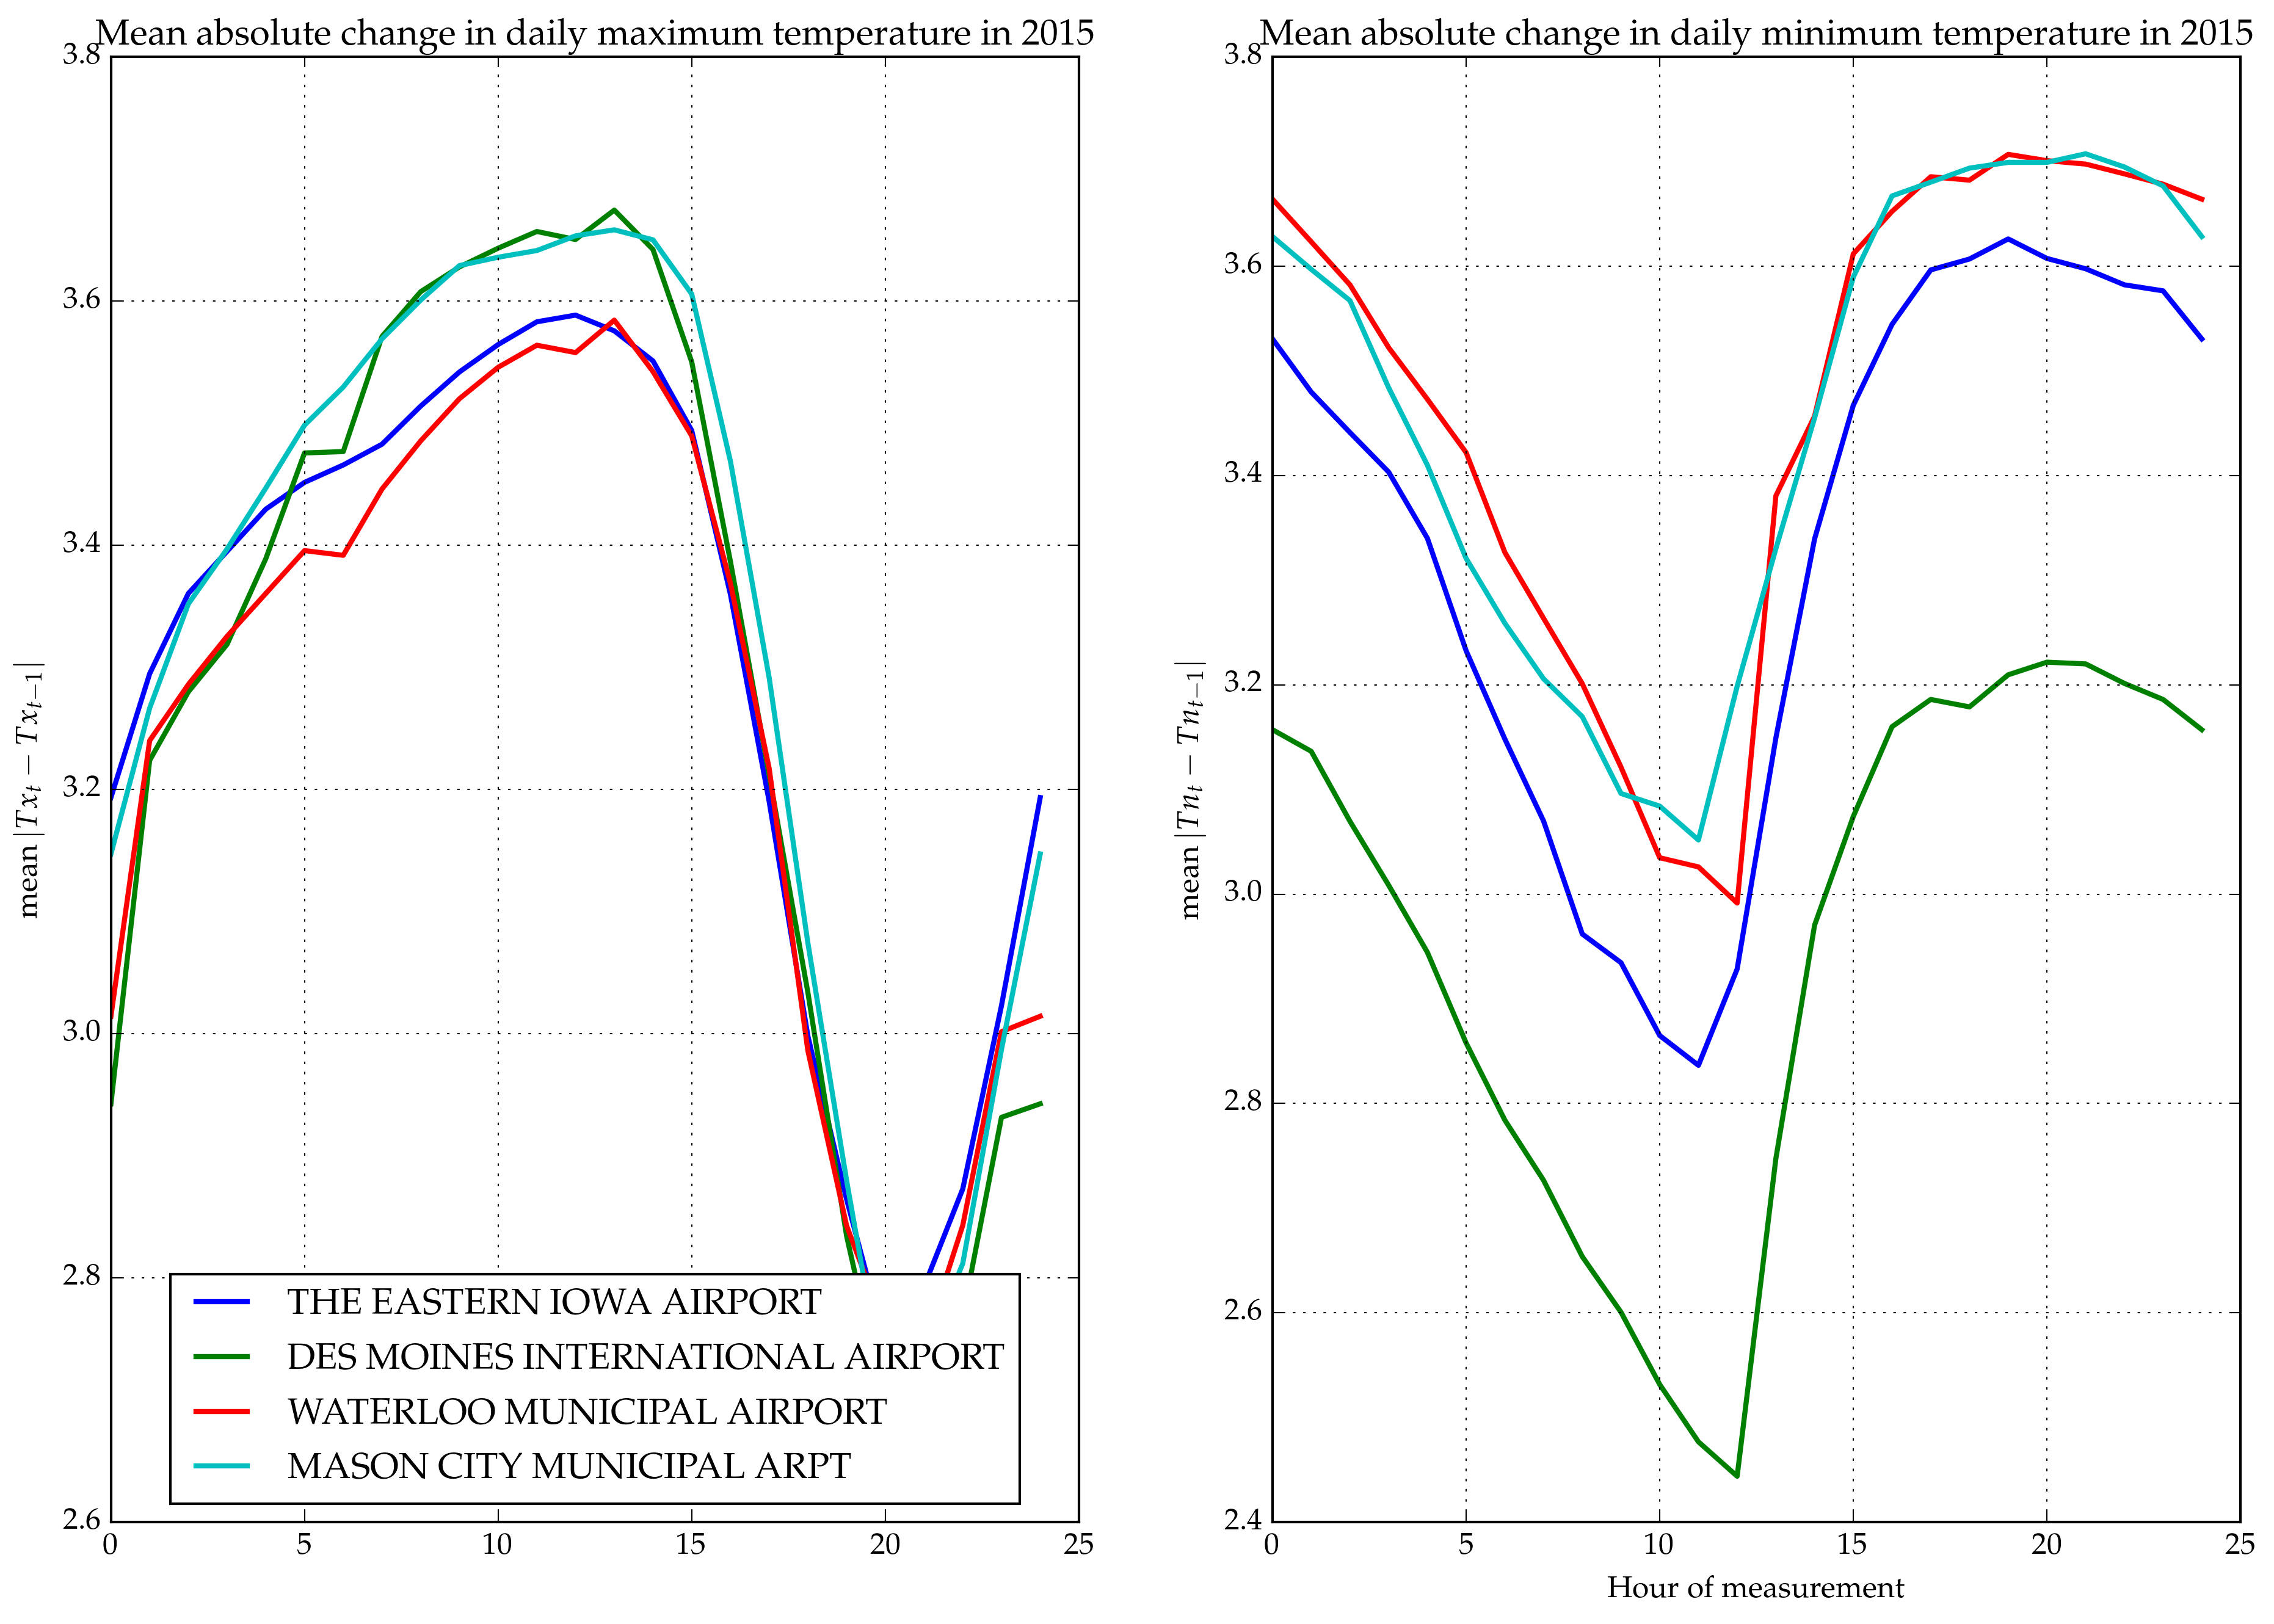

In [13]:
plt.subplot(1,2,1)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for hr in Hour(0):Hour(24)
        hr_mdiff = DataFrames.by(TnTx_dict[hr], :station, 
            df -> mean(abs(diff(df[:Tx].values))))
        for station in 1:4
            push!(meandiff[station], get(hr_mdiff[station,:x1]))
        end
    end

    for station in 1:4
        plt.plot(0:24, meandiff[station], linewidth=2, label=get(isdSubset[station,:NAME]))
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tx_{t}-Tx_{t-1} \right|$")
    plt.title("Mean absolute change in daily maximum temperature in 2015")
    plt.grid()
    plt.legend(loc="lower center")
end
plt.subplot(1,2,2)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for hr in Hour(0):Hour(24)
        hr_mdiff = DataFrames.by(TnTx_dict[hr], :station, 
            df -> mean(abs(diff(df[:Tn].values))))
        for station in 1:4
            push!(meandiff[station], get(hr_mdiff[station,:x1]))
        end
    end

    for station in 1:4
        plt.plot(0:24, meandiff[station], linewidth=2)
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tn_{t}-Tn_{t-1} \right|$")
    plt.title("Mean absolute change in daily minimum temperature in 2015")
    plt.xlabel("Hour of measurement")
    plt.grid(true)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
;

## Proposed solution

We have seen that the daily maxima and minima do not faithfully record each diurnal cycle's peak and trough. 
The peaks on a relatively cold day can get overwritten by temperatures at either end of the measurement window that properly belong to the previous or the next diurnal cycle. 
Troughs on relatively warm days can be similarly overwritten. 
Our goal is to undo this damage, and recover estimates of summary statistics, such as the average daily maximum temperature, that do not suffer from the consequent bias. 
We need to address the erasure of information caused by the measurement mechanism, and therefore view this as a missing data problem.

Taking the missing data perspective, we seek to impute the hourly temperatures that have been replaced by a maximum and minimum over a 24 hour period. 
To do so, we use information from two sources: the recorded daily temperature extremes at the station of interest, and also hourly temperatures recorded at nearby meteorological stations. 
These hourly measurements are considered less reliable by climatologists, as they aren't as carefully documented, calibrated, and situated. 
The meterological stations are often in locations (like airports) where human activity will affect temperatures.
Therefore, summary statistics extracted directly from those measurements would not be directly usable for climatology, as they could suffer from systematic bias.
However, even if miscalibrated, the meterological data do contain valuable information about the hourly changes in temperatures on any given day.
We therefore use them to inform the shape of the imputed temperature time-series at our location of interest,
while we use the recorded temperature extrema to calibrate and constrain them.

# First Spatiotemporal Model

To model measured temperatures at various locations and times, we use a spatio-temporal Gaussian process model. 
In its simplest form, we believe that temperatures from stations that are near each other are more correlated than distant stations, and that those correlations should also decay in time. 
In the spatial statistics literature, squared exponential covariance functions are commonly used to model correlations decaying as a function of distance. 
Ignoring the time dimension, we would model the simultaneous temperatures throughout a region as a Gaussian process, with the covariance of two locations $\xvec$ and $\xvec'$
\begin{equation}
    \cov\del{T(\xvec), T(\xvec') \mid t} = k_{space}(\xvec, \xvec') = \sigmaf^2 \exp\del{-\frac{\del{\xvec-\xvec'}\trans\del{\xvec-\xvec'}}{2\ell_x^2}}\,.
\end{equation}
Similarly, ignoring the spatial dimension, the time series of temperatures at a single location can be modeled as a Gaussian process with covariance between two moments $t$ and $t'$
\begin{equation}
\cov\del{T(t), T(t') \mid \xvec} = k_{time}(t, t') = \sigmaf^2 \exp\del{-\frac{\del{t-t'}^2}{2\ell_t^2}}\,.
\end{equation}
We then combine the spatial and temporal model by multiplying the covariance functions
\begin{equation}
k_{st}(\xvec,\xvec',t,t') = k_{time}(t,t') \cdot k_{space}(\xvec, \xvec')\,.
\end{equation}
This gives us the covariance of the Gaussian process underlying the full spatio-temporal model of temperatures.
To complete the model specification, we add a mean temperature for each station $\mu_{\station{i}}$, and iid measurement noise $\epsilon_i$.
\begin{align}
    T_i &= \mu_{\station{i}} + f(\xvec_i, t_i) + \epsilon_i\\
    f(\xvec_i, t_i) &\sim \GP\del{0, k_{st}(\xvec,\xvec',t,t')}\\
    \epsilon_i &\overset{\iid}{\sim} \normal\del{0,\sigman^2}\\
\end{align}

# Fitting the spatiotemporal model

Software is readily available in many programming languages for fitting Gaussian process models, including inference on the covariance parameters. We chose to use the julia `GaussianProcesses.jl` package to fit the above spatiotemporal model to the hourly temperatures at four Iowa weather stations. However, the Iowa data includes X measurements, which is computationally infeasible to fit directly with a single Gaussian process. While approximation techniques exist to fit such large datasets, we chose the less efficient but simpler approach of dividing the data into 10-day chunks, modeled as independent Gaussian processes with shared hyperparameters. To simplify our implementation, we replaced the $\mu_\station{i}$ terms by a spatial squared exponential component
\begin{equation}
    k_{\mu}(\xvec, \xvec') = \sigma_\mu^2 \exp\del{-\frac{\del{\xvec-\xvec'}\trans\del{\xvec-\xvec'}}{2\ell_\mu^2}}
\end{equation}
with large variance $\sigma_\mu^2$ and low lengthscale $\ell_\mu$ added to the covariance function so that the spatio-temporal kernel becomes
\begin{equation}
    k_{st}(\xvec,\xvec',t,t') = k_{time}(t,t') \cdot k_{space}(\xvec, \xvec') + k_\mu(\xvec, \xvec') \,.
\end{equation}
The entire model therefore has 3 parameters: $\sigmaf$, $\ell$, and $\sigman$. By optimizing the marginal likelihood of the Iowa data as a function of these three parameters, we obtained $\sigmaf=3.73\,\degreeC$, $\ell=176.4\,\mathrm{km}$ and $\sigman=0.44\,\degreeC$.

1. timeseries model
    * fitting hyperparameters
    * chunks
    * show variogram
2. spatiotemporal model
    * fitting hyperparameters
    * chunks
3. imputations
    * Stan
    * softmin and softmax
    * observation noise
    * reparametrization

   
# Improving model    
1. focused on timeseries model
    * kernel components
    * diurnal cycle
    * show improved variograms
2. spatiotemporal model
    * variograms and cross-variograms
    * trace evolution
        * product kernel
        * sum of products with variance 1
        * sum of products with free variance
    * for each model, report marginal likelihood, and predictive diagnostic in a table
    * discuss importance of getting uncertainty right

# Analysis
* show imputations on interesting days
* show imputations can capture two possible explanations for a measurement
* discuss possibility of inferring measurement time